# Objective

The objective of this project is to use a basic Convolutional Neural Network (CNN) to identify alphabetic characters from 28 x 28 pixel images.

The dataset for this notebook is from a Kaggle dataset:
https://www.kaggle.com/sachinpatel21/az-handwritten-alphabets-in-csv-format

The dataset is titled A-Z Handwritten Alphabets in .csv format

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_csv("/Users/ericwolos/ML/archive/handwrittenAlphabet.csv")

Dataset contains 372,450 images, each 28 x 28 pixels
Unfortunately they are not formatted in a 3 dimensional array yet

In [3]:
print(dataset.shape)
print(dataset)

(372450, 785)
         0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.639  0.640  \
0        0    0    0    0    0    0    0    0    0    0  ...      0      0   
1        0    0    0    0    0    0    0    0    0    0  ...      0      0   
2        0    0    0    0    0    0    0    0    0    0  ...      0      0   
3        0    0    0    0    0    0    0    0    0    0  ...      0      0   
4        0    0    0    0    0    0    0    0    0    0  ...      0      0   
...     ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
372445  25    0    0    0    0    0    0    0    0    0  ...      0      0   
372446  25    0    0    0    0    0    0    0    0    0  ...      0      0   
372447  25    0    0    0    0    0    0    0    0    0  ...      0      0   
372448  25    0    0    0    0    0    0    0    0    0  ...      0      0   
372449  25    0    0    0    0    0    0    0    0    0  ...      0      0   

        0.641  0.642  0.643  0.644  0.645  0.646 

Please note that the first column of the set contains relevant labels. These labels correspond to an index and begin at 0 (a) and end at 25 (z).

# Preprocessing

First, images will be reformatted into 28 x 28 instead of remaining flattened 

In [4]:
datasetFeatures = dataset.drop(columns=['0'])
datasetLabels = dataset['0'].to_numpy()
datasetLabels = datasetLabels#.reshape(datasetLabels.shape[0], 1)

# Division by 255 acts as normalization
datasetUnflattened = datasetFeatures.to_numpy().reshape(-1, 28, 28, 1)/255

Next, the dataset will be split into training and testing data. In this case, 20% of data will be used for testing and the other 80% will be used for training.

In [5]:
TrainFeatures, TestFeatures, TrainLabels, TestLabels = train_test_split(datasetUnflattened, datasetLabels, test_size = 0.2, stratify = datasetLabels)


In [6]:
print("Training features are shaped {}".format(TrainFeatures.shape))
print("Testing features are shaped {}".format(TestFeatures.shape))
print("Training labels are shaped {}".format(TrainLabels.shape))
print("Testing labels are shaped {}".format(TestLabels.shape))

Training features are shaped (297960, 28, 28, 1)
Testing features are shaped (74490, 28, 28, 1)
Training labels are shaped (297960,)
Testing labels are shaped (74490,)


In [7]:
# Assemble both datasets
trainDataset = tf.data.Dataset.from_tensor_slices((TrainFeatures, TrainLabels))
testDataset = tf.data.Dataset.from_tensor_slices((TestFeatures,TestLabels))


In [8]:
numTrainLabels = TrainLabels.shape[0]
batchSize = 32

trainDataset = trainDataset.cache().repeat().shuffle(numTrainLabels).batch(batchSize)
testDataset = testDataset.cache().repeat().batch(batchSize)


# Visualization

Next, I'll look at some of the images and their labels

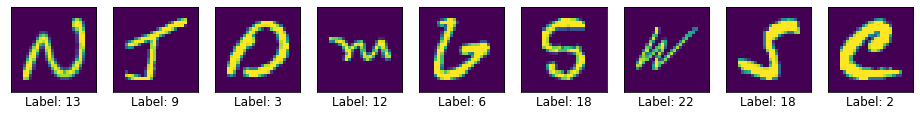

In [9]:
# this function returns a row of n images starting at startImageNum where n is numImages

def getImages(numImages, startImageNum):
    figure = plt.figure(figsize=(18,18))
    
    for imageNum in range(1,numImages):
        
        startImage = startImageNum + imageNum
        
        figure.add_subplot(1, numImages, imageNum)
        
        plt.imshow(TrainFeatures[startImage])
        plt.xlabel("Label: " + str(TrainLabels[startImage]), fontsize = 12)
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

getImages(10, 100)


The labels correspond to the correct handwritten letters

# Model Construction

In [10]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape = (28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2), strides = 2),
    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides = 2),
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(26, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

The model requires compilation as well. 

In [11]:
myAdam = tf.keras.optimizers.Adam(learning_rate = 0.0005)

model.compile(
    optimizer = myAdam,
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

I'd like to ensure that the model does not get overfit because of too many epochs. An Early Stopper will stop model training if a certain change in accuracy is not met.

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=1, min_delta = 0.01)

# Model Training & Testing

In [13]:
history = model.fit(trainDataset, epochs = 10, steps_per_epoch = math.ceil(numTrainLabels/batchSize), callbacks = [callback])

Epoch 1/10
9312/9312 [==============================] - 147s 16ms/step - loss: 0.1433 - accuracy: 0.9596
Epoch 2/10
9312/9312 [==============================] - 142s 15ms/step - loss: 0.0539 - accuracy: 0.9849
Epoch 3/10
9312/9312 [==============================] - 146s 16ms/step - loss: 0.0346 - accuracy: 0.9901


In [14]:
testLoss, testAccuracy = model.evaluate(testDataset, steps = math.ceil(numTrainLabels/batchSize))
print('Test dataset Accuracy:', str(testAccuracy * 100), '%')

9312/9312 [==============================] - 36s 4ms/step - loss: 0.0362 - accuracy: 0.9899
Test dataset Accuracy: 98.98786544799805 %


# Further Visualization 

Now let's see some images and respective model predictions to visually confirm model success

In [15]:
for testImages, imageLabels in testDataset.take(1):
    testImages = testImages.numpy()
    imageLabels = imageLabels.numpy()
    predictions = model.predict(testImages)

Let's look at 10 images and their predictions

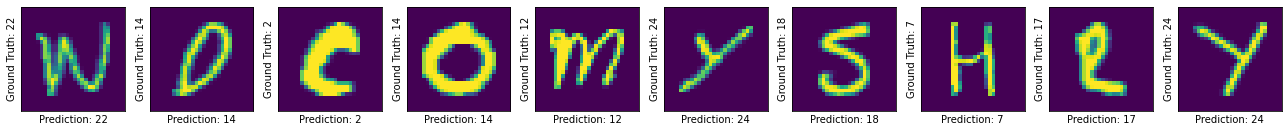

In [16]:
# This function will compare ground truth to model predictions
def compareTruth(numImages):
    figure = plt.figure(figsize = (18,18))
    for imageNum in range(1,numImages + 1):
        
        figure.add_subplot(1, numImages, imageNum)

        plt.imshow(testImages[imageNum])
        
        plt.xlabel("Prediction: " + str(np.argmax(predictions[imageNum])), fontsize = 10)
        plt.ylabel("Ground Truth: " + str(imageLabels[imageNum]), fontsize = 10)
        plt.xticks([])
        plt.yticks([])
        
    plt.tight_layout()
    plt.show()

    
numImages = 10
compareTruth(numImages)